In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import pandas
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as transforms
import numpy as np
from matplotlib.lines import Line2D
import groupPolylines
import pcaSpiralExtract

In [5]:
wrapColor = lambda color, s: '{}{}\033[0m'.format(color, s)
red = lambda s: wrapColor('\033[31m', s)
green = lambda s: wrapColor('\033[32m', s)
yellow = lambda s: wrapColor('\033[33m', s)
blue = lambda s: wrapColor('\033[34m', s)
purple = lambda s: wrapColor('\033[35m', s)
print(red('I'), green('really'), yellow('really'), blue('like'), purple('rainbows'))

I really really like rainbows


In [6]:
classifications = pandas.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pandas.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
print(classifications.info())
print(subjects.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5638 entries, 0 to 5637
Data columns (total 14 columns):
classification_id    5638 non-null int64
user_name            5638 non-null object
user_id              4041 non-null float64
user_ip              5638 non-null object
workflow_id          5638 non-null int64
workflow_name        5638 non-null object
workflow_version     5638 non-null float64
created_at           5638 non-null object
gold_standard        0 non-null float64
expert               0 non-null float64
metadata             5638 non-null object
annotations          5638 non-null object
subject_data         5638 non-null object
subject_ids          5638 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 616.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 9 columns):
subject_id               391 non-null int64
project_id               391 non-null int64
workflow_id              342 non-null float64
sub

In [7]:
getUrl = lambda id: eval(subjects[subjects['subject_id'] == id]['locations'].iloc[0])['1']

In [8]:
most_recent_workflow = classifications.workflow_version == 61.107
classifications[most_recent_workflow].groupby('subject_ids')
classificationsCounts = classifications[most_recent_workflow]['subject_ids'].value_counts()
subjIds = np.array(classificationsCounts[classificationsCounts > 25].index)

print('Identified {} subjects with more than 25 classifications'.format(purple(subjIds.shape[0])))

Identified 56 subjects with more than 25 classifications


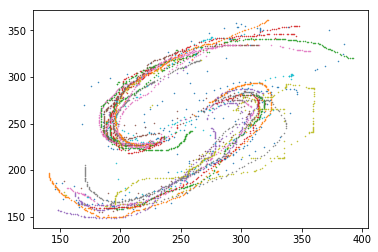

In [9]:
null = None
true = True
false = False

annotationsForSubject = [
    eval(foo) for foo in 
    classifications[classifications['subject_ids'] == subjIds[6]]['annotations']
]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotationsForSubject if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])
for arm in drawnArms:
    plt.plot(arm[:, 0], arm[:, 1], '.', markersize=1)

In [10]:
db = groupPolylines.clusterPolyLines(drawnArms)
armLabels = db.labels_

1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 2


In [61]:
print(db.core_sample_indices_)
print(db.labels_)

[ 1  2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 34 35 36 37 38 41 42 43 44 45 46]
[-1  0  1  1  0  1  0  1 -1 -1 -1  0  1  1  0 -1  1  0  0  1  0  1  1  0
  1  0  1  0  0  1  0  1  0  1  0  1  1  0  1 -1 -1  0  1  1  0  0  1]


In [62]:
distances = groupPolylines.calculateDistanceMatrix(drawnArms)

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distances)

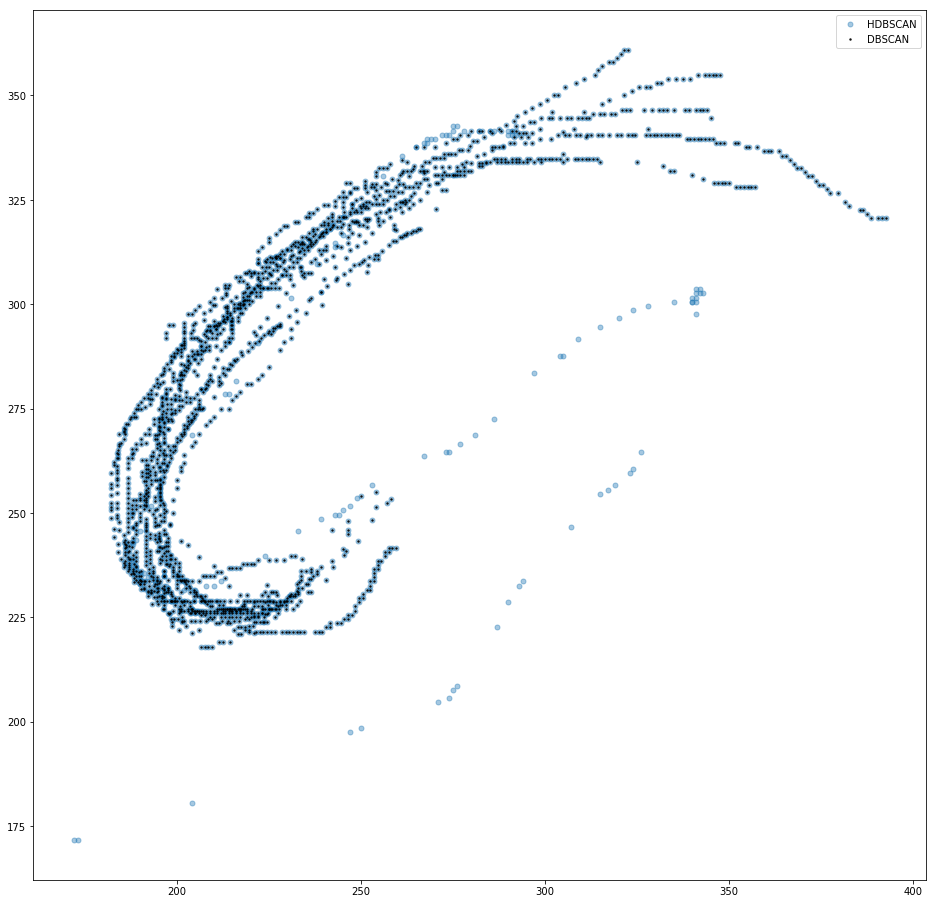

In [58]:
plt.figure(figsize=(16,16))
pc = np.concatenate(drawnArms[clusterer.labels_ == 0])
pc2 = np.concatenate(drawnArms[db.labels_ == 1])
plt.plot(pc[:, 0], pc[:, 1], '.', markersize=10, alpha=0.4, label='HDBSCAN')
plt.plot(pc2[:, 0], pc2[:, 1], '.k', markersize=3, alpha=0.8, label='DBSCAN')
plt.legend()